In [8]:
import matplotlib.pyplot as plt
import numpy as np
from pydap.net import create_session
import json
import cartopy.crs as ccrs
import xarray as xr
import datetime as dt
from pydap.client import open_url, consolidate_metadata, get_cmr_urls
import earthaccess
import pydap

In [3]:
print("pydap version: ", pydap.__version__)

pydap version:  3.5.7.dev2+gafd8e4c


<span style='color:#ff6666'><font size="5">**Finding Cloud OPeNDAP URLs with NASA's CMR**:

<span style='font-family:serif'> <font size="3"><span style='color:Black'> Below we illustrate how to find OPeNDAP URLs via the **CMR**

<span style='color:#0066cc'><font size="3.5"> **To find (cloud) OPeNDAP URL you will need:**

* One of `Collection Concept ID` or `dataset DOI`
* Time Range


Here, we will use the Collection Concept ID associated with the [Temperature and Salinity](https://podaac.jpl.nasa.gov/dataset/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4). For example:

<img src="img/ECCO_conceptID_doi.png" alt="drawing" width="750"/>    





In [ ]:
session = requests.Session()

In [10]:
# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/'
doi = '10.5067/ECL5M-OTS44'

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Specify time range**

<font size="3"><span style='color:Black'> This dataset covers `01-01-1992` to `01-18-2018`. 


In [5]:
start_date =  dt.datetime(1992, 1, 1)
end_date = dt.datetime(2017, 12, 31)

time_range=[start_date,end_date] # One month of data


<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Get all available cloud OPeNDAP URLs via CMR**

The cell below will search/find all OPeNDAP URLs associated with the Collection concept ID.

The results wll be stored in the variable `granules_urls`.
    

In [18]:
%%time
granules_urls = get_cmr_urls(doi=doi, time_range=time_range, limit=100)

CPU times: user 16.6 ms, sys: 6.82 ms, total: 23.4 ms
Wall time: 1.39 s


In [19]:
print("WE found: ", len(granules_urls), " total Cloud OPeNDAP URLS associated with this collection!")

WE found:  100  total Cloud OPeNDAP URLS associated with this collection!


<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Pydap Approach**

<span style='font-family:serif'> <font size="3.5"> We can use <span style='color:#ff6666'>**PyDAP**<span style='color:black'> to inspect the metadata associated with each of the urls.

<span style='font-family:serif'> <font size="3.5">Below we illustrate the use of <span style='color:#ff6666'>**PyDAP**<span style='color:black'> with Token authentication to access OPeNDAP metadata.

<span style='font-family:serif'> <font size="3.5"> This will be useful when accessing OPeNDAP URLs via xarray.


<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Import Token Authorization and create Session**

<span style='font-family:serif'> <font size="3.5"> Here, we use `earthaccess` to authenticate and extract the user token from EDL. It will all happen in the background, but you will be prompted to add your EDL credentials.


In [16]:
auth = earthaccess.login(strategy="interactive", persist=True) # you will be promted to add your EDL credentials

# pass Token Authorization to a new Session.
cache_kwargs={'cache_name':'ECCOv4'}
my_session = create_session(use_cache=True, session=auth.get_session(), cache_kwargs=cache_kwargs)
my_session.cache.clear()

<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Lazy access to remote data via pydap's client API**

<font size="3"> <span style='color:#ff6666'>**PyDAP**<span style='color:black'> exploits the OPeNDAP's separation between metadata and data, to create lazy dataset objects that point to the data. These lazy objects contain all the attributes detailed in OPeNDAP's metadata files (DMR)

In [20]:
%%time
pyds = open_url(granules_urls[0], session=my_session, protocol='dap4')

CPU times: user 50.1 ms, sys: 10.4 ms, total: 60.5 ms
Wall time: 3.63 s


In [21]:
pyds.tree()

.OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-01_ECCO_V4r4_native_llc0090.nc
├──XG
├──Zp1
├──Zl
├──YC
├──XC
├──SALT
├──YG
├──XC_bnds
├──Zu
├──THETA
├──Z_bnds
├──YC_bnds
├──time_bnds
├──Z
├──i
├──i_g
├──j
├──j_g
├──k
├──k_l
├──k_p1
├──k_u
├──nb
├──nv
├──tile
└──time


<span style='font-family:serif'> <font size="5.5"><span style='color:#0066cc'> **Not all Variables are of interest. Lets use Constraint Expressions!**

<font size="3">  Consider that we only want
- `THETA`
- `SALT`

<font size="3">  and their `dimensions`. 

In [22]:
print("dimension of THETA:" , pyds['THETA'].dims)
print("dimension of SALT:" , pyds['SALT'].dims)

dimension of THETA: ['/time', '/k', '/tile', '/j', '/i']
dimension of SALT: ['/time', '/k', '/tile', '/j', '/i']


<span style='color:#0066cc'><font size="5"> **Construct Constraint Expression**

<font size="3"> That will instruct the Hyrax Data Server to only give use our desired variables.

<font size="3">  This variable will be named `CE`. We will add it to each (granule) cloud OPeNDAP URL. THis will allow us to construct a `Data Cube`


In [23]:
dims = pyds['SALT'].dims
Vars = ['/THETA', '/SALT'] + dims

# Below construct Contraint Expression
CE = "?dap4.ce="+(";").join(Vars)
print("constraint expression: ", CE)

constraint expression:  ?dap4.ce=/THETA;/SALT;/time;/k;/tile;/j;/i


In [24]:
print(" Each Cloud OPeNDAP URL will look like: \n", granules_urls[0]+CE)

 Each Cloud OPeNDAP URL will look like: 
 https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-01_ECCO_V4r4_native_llc0090?dap4.ce=/THETA;/SALT;/time;/k;/tile;/j;/i


<span style='color:#0066cc'><font size="5"> **Construct DAP4 URLS:**
 

<font size="3"> A DAP4 url begins with `dap4` as a scheme. 

<font size="3"> **NOTE**: This is only for xarray and <span style='color:#ff6666'>**PyDAP**<span style='color:black'>.


In [25]:
new_urls = [url.replace("https", "dap4") + CE for url in granules_urls][:100] # consider only the first 100 urls
new_urls[:4]

['dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-01_ECCO_V4r4_native_llc0090?dap4.ce=/THETA;/SALT;/time;/k;/tile;/j;/i',
 'dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-02_ECCO_V4r4_native_llc0090?dap4.ce=/THETA;/SALT;/time;/k;/tile;/j;/i',
 'dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-03_ECCO_V4r4_native_llc0090?dap4.ce=/THETA;/SALT;/time;/k;/tile;/j;/i',
 'dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salin

<span style='color:#0066cc'><font size="5"> **Consolidate all URL Metadata Associated with the Data URL of cloud OPeNDAP URLs**

<font size="3"> You can construct a persistent reference to all Cloud OPeNDAP urls for later use!!!! 


In [26]:
# clear just in case
my_session.cache.clear()

In [27]:
%%time
consolidate_metadata(new_urls, my_session, concat_dim='time')

datacube has dimensions ['i[0:1:89]', 'j[0:1:89]', 'k[0:1:49]', 'tile[0:1:12]'] , and concat dim: `time`
CPU times: user 1.25 s, sys: 521 ms, total: 1.77 s
Wall time: 33.5 s


## What happened?

<font size="3"> All necessary metadata was fetch from opendap servers, and it can be used and reused by xarray. 


## Create a datacube with xarray and pydap as an engine!


In [31]:
%%time
ds = xr.open_mfdataset(new_urls, engine='pydap', session=my_session, parallel=True, combine='nested', concat_dim='time', chunks={'tile':1, 'k':1})
ds

CPU times: user 1.38 s, sys: 193 ms, total: 1.58 s
Wall time: 1.45 s


<xarray.Dataset> Size: 4GB
Dimensions:  (time: 100, k: 50, tile: 13, j: 90, i: 90)
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 800B 1992-01-16T18:00:00 ... 2000-04-16
Data variables:
    SALT     (time, k, tile, j, i) float32 2GB dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
    THETA    (time, k, tile, j, i) float32 2GB dask.array<chunksize=(1, 1, 1, 90, 90), meta=np.ndarray>
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            f07693e6-4181-11eb-beb3-0cc47a3f44ff

## Download some data

So far, only metadata has been downloaded. Below we plot some data in the NorthAtlantic ocean





CPU times: user 197 ms, sys: 23.2 ms, total: 221 ms
Wall time: 5.51 s


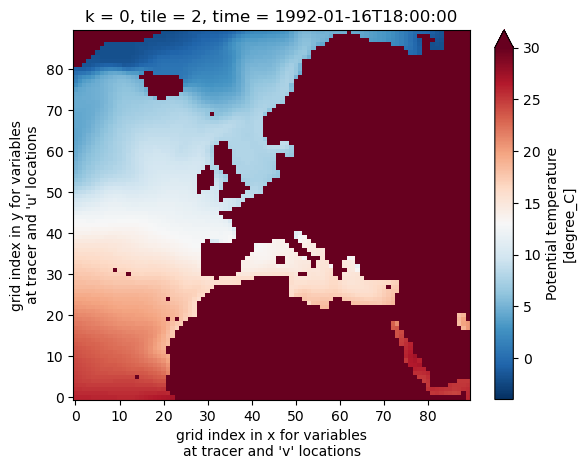

In [32]:
%%time
ds['THETA'].isel(time=0, k=0, tile=2).plot(cmap='RdBu_r', vmin=-4, vmax=30);

In [33]:
ds['THETA'].isel(time=0, k=0, tile=2).attrs

{'long_name': 'Potential temperature ',
 'units': 'degree_C',
 'coverage_content_type': 'modelResult',
 'standard_name': 'sea_water_potential_temperature',
 'comment': 'Sea water potential temperature is the temperature a parcel of sea water would have if moved adiabatically to sea level pressure. Note: the equation of state is a modified UNESCO formula by Jackett and McDougall (1995), which uses the model variable potential temperature as input assuming a horizontally and temporally constant pressure of $p_0=-g \rho_{0} z$.',
 'valid_min': -2.2909388542175293,
 'valid_max': 36.032955169677734,
 'origname': 'THETA',
 'fullnamepath': '/THETA',
 'Maps': ()}